In [1]:
from sklearn.model_selection import train_test_split, cross_validate
import pandas as pd
import numpy as np
from joblib import parallel_backend
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
#model import
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
# 분류기 정의
xgb = XGBClassifier(n_jobs=-1, random_state=42)
lgbm = LGBMClassifier(random_state=42)
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
extra_trees = ExtraTreesClassifier(random_state=42)
adaboost = AdaBoostClassifier(random_state=42)
xgboost = XGBRFClassifier(random_state=42)

In [10]:
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBRFClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from scipy.stats import randint

# 파일 불러오기
df = pd.read_csv('./df_train_v3_mean.csv')
data = df.drop(columns=['answer', 'year', 'month', 'day', 'hour'])
target = df['answer']

# 데이터 전처리 (StandardScaler)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Train-Validation 분할
X_train, X_val, y_train, y_val = train_test_split(data_scaled, target, test_size=0.2, random_state=123, stratify=target)

# AdaBoostClassifier의 최적 파라미터 탐색
adaboost_params = {'learning_rate': [0.01, 1.0], 'n_estimators': randint(50, 300)}
adaboost = AdaBoostClassifier(random_state=42)
adaboost_gs = RandomizedSearchCV(adaboost, adaboost_params, n_iter=100, n_jobs=-1, random_state=42)
adaboost_gs.fit(X_train, y_train)
adaboost_best_params = adaboost_gs.best_params_

# XGBRFClassifier의 최적 파라미터 탐색
xgbrf_params = {'n_estimators': randint(50, 300),
                'max_depth': randint(0, 51),
                'learning_rate': [0.01,0.3],
                'subsample': [0.1, 1.0],
                'colsample_bytree': [0.1, 0.9],
                'gamma': [0, 5]}
xgbrf = XGBRFClassifier(random_state=42)
xgbrf_gs = RandomizedSearchCV(xgbrf, xgbrf_params, n_iter=100, n_jobs=-1, random_state=42)
xgbrf_gs.fit(X_train, y_train)
xgbrf_best_params = xgbrf_gs.best_params_

# VotingClassifier로 앙상블 모델 생성
ensemble = VotingClassifier(estimators=[('adaboost', AdaBoostClassifier(**adaboost_best_params)),
                                        ('xgboost', XGBRFClassifier(**xgbrf_best_params))], voting='hard')

# 앙상블 모델 훈련
ensemble.fit(X_train, y_train)

# 훈련 세트와 검증 세트에 대한 예측값 계산
train_pred = ensemble.predict(X_train)
val_pred = ensemble.predict(X_val)

# 훈련 세트와 검증 세트의 정확도 계산
train_accuracy = accuracy_score(y_train, train_pred)
val_accuracy = accuracy_score(y_val, val_pred)

# 결과 출력
print("AdaBoostClassifier와 XGBRFClassifier 앙상블 결과")
print("AdaBoostClassifier 최적 파라미터:", adaboost_best_params)
print("XGBRFClassifier 최적 파라미터:", xgbrf_best_params)
print("훈련 세트 정확도:", train_accuracy)
print("검증 세트 정확도:", val_accuracy)

AdaBoostClassifier와 XGBRFClassifier 앙상블 결과
AdaBoostClassifier 최적 파라미터: {'learning_rate': 1.0, 'n_estimators': 269}
XGBRFClassifier 최적 파라미터: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 24, 'n_estimators': 142, 'subsample': 1.0}
훈련 세트 정확도: 0.9622844827586207
검증 세트 정확도: 0.9224137931034483


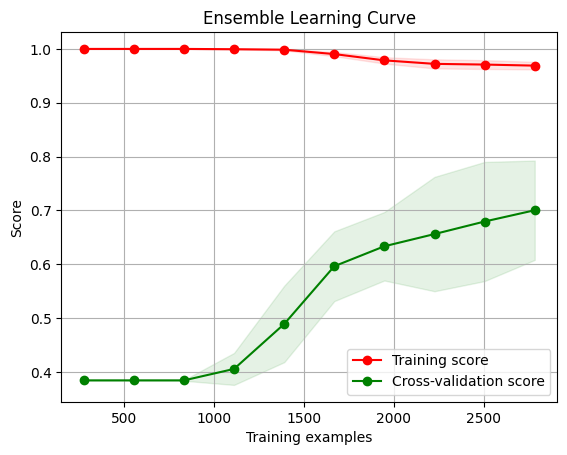

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

# 학습 곡선을 그리는 함수
def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(estimator, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy', n_jobs=-1)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")

# 학습 곡선 그리기
plot_learning_curve(ensemble, data_scaled, target, "Ensemble Learning Curve")
plt.show()